In [ ]:
!pip install transformers==4.1.1 &> /dev/null
import importlib
import sys
importlib.reload(sys.modules['pkg_resources'])

sys.modules['pkg_resources'].get_distribution('tokenizers').version

import transformers
transformers.__version__

'4.1.1'

In [ ]:
!pip install mendelai-brat-parser &> /dev/null
from brat_parser import get_entities_relations_attributes_groups

import torch 
import spacy
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

#!pip uninstall nltk &> /dev/null
#!pip install -U nltk &> /dev/null
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('punkt')

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm, trange

MAX_LEN = 75
batch_size = 32

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1: NER

## Data Extraction

In [ ]:
PATH = "/content/drive/MyDrive/CMED/Data/trainingdata_v3/train"

def read_annotated_files(PATH):

    print("Reading Files")

    train = pd.DataFrame(columns = ["Id","Doc_Id","Sent_Id","Word","Tag"])

    sent_id = 0
    id = 0
    doc_id = 0
     
    files = glob(PATH + '/*')
    for path in files:
    
      if path.endswith(".ann"):
        continue
      
      doc_id += 1
      if doc_id % 25 == 0:
        print(doc_id,end = ' ')

      span = 0
      with open(path) as txt:
        raw = txt.read()

      entities,_,_,_ = get_entities_relations_attributes_groups(path.replace(".txt",".ann"))
      entl = []
      for i in entities:
        if (entities[i].span.__len__())>1:
          entities[i].span = ((entities[i].span[0][0],entities[i].span[-1][-1]),)
        entl.append([*entities[i].span[0],entities[i].text,entities[i].type])
      entl = sorted(entl)[::-1]

      for sent in sent_tokenize(raw):
        sent_id += 1
        for word in word_tokenize(sent):
          id += 1
          train = train.append(pd.DataFrame(data = np.array([[id,doc_id,sent_id,word,np.nan]]),columns = ["Id","Doc_Id","Sent_Id","Word","Tag"]))
          span += raw[span:].find(word)
          while True:
            if len(entl)>0 and entl[-1][0] <= span:
              if entl[-1][1] <= span:
                entl.pop()
              else:
                if span == entl[-1][0]:
                  train.iloc[-1,-1] = "B-" + entl[-1][3]
                else:
                  train.iloc[-1,-1] = "I-" + entl[-1][3]
                break
            else:
              train.iloc[-1,-1] = 'O'
              break
    return train,files

#train,_ = read_annotated_files(PATH)

In [ ]:
#train.to_csv("TRAIN_CMED_NER_BIO2.csv")

## Data Preprocessing

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/CMED/Task 1: Named Entity Recognition/TRAIN_CMED_NER_BIO2.csv")
train_ner = train.copy()
train_ner = train_ner.drop(np.where(train_ner["Word"].isnull())[0],axis=0)
train_ner["Tag"] = [word[0] for word in train_ner["Tag"]]
train_ner = train_ner.set_index("Id")
train_ner = train_ner.drop("Unnamed: 0",axis = 1)
del train
train_ner.head()

,Doc_Id,Sent_Id,Word,Tag
Id,,,,
1,1,1,Record,O
2,1,1,date,O
3,1,1,:,O
4,1,1,2086-04-18,O
5,1,1,ZASTROW,O


In [ ]:
grp_obj = train_ner.groupby("Sent_Id").apply(lambda x:[(word,label) for word,label in zip(x["Word"],x["Tag"])])

sentences = [[tpl[0] for tpl in sent] for sent in grp_obj]
labels = [[tpl[1] for tpl in sent] for sent in grp_obj]

saved_sentences = sentences
saved_labels = labels
 
tag_values = list(set(train_ner["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 

def get_tokenized_sentences_and_labels(sentences,labels,tokenizer):

  sent = []
  lab = []

  for i,j in zip(sentences,labels):
    sent.append([])
    lab.append([])
    for ind in range(len(i)):
      temp = tokenizer.tokenize(i[ind])
      sent[-1].extend(temp)
      lab[-1].extend((j[ind]*len(temp)))
  return sent,lab
  
sentences,labels = get_tokenized_sentences_and_labels(sentences,labels,tokenizer)

In [ ]:
def normalize_longer_sequences():
  global sentences,labels

  inds = []

  for i in range(len(sentences)):
    if len(sentences[i]) > MAX_LEN:
      inds.append(i)

  temp_sent = np.array(sentences,dtype = object)[inds]
  temp_lab = np.array(labels,dtype = object)[inds]

  sentences = np.delete(np.array(sentences,dtype = object),inds,0)
  labels = np.delete(np.array(labels,dtype = object),inds,0)

  save_sent = []
  save_lab = []
  for i in range(len(temp_sent)):
    for k in range(len(temp_sent[i])//(MAX_LEN//2)-1):
      save_sent.append(temp_sent[i][k*(MAX_LEN//2):k*(MAX_LEN//2)+75])
      save_lab.append(temp_lab[i][k*(MAX_LEN//2):k*(MAX_LEN//2)+75])

  sentences = np.concatenate([sentences,save_sent],axis = 0)
  labels = np.concatenate([labels,save_lab],axis = 0)

normalize_longer_sequences()

for i,j in zip(sentences,labels):
  assert(len(i) == len(j))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, tr_tags, tr_masks = input_ids, tags, attention_masks

tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

## Model 

### BERT

#### Utility procedures for training BERT

##### Helper Function for BERT Predictions

In [ ]:
def get_span_from_predictions(raw,sentences,labels):
  addingstatus = span = 0
  sent = []
  lab = []
  for i,j in zip(sentences,labels):
    sent.extend(i)
    lab.extend(j)
  for i in range(len(lab)):
    if lab[i] == 'PAD':
        lab[i] = 'O'
  prev = 'O'
  df = pd.DataFrame(columns = ["span","text"])
  for i,j in zip(sent,lab):
    span += raw[span:].find(i)
    if prev == 'O':
        prev = j
        if j == 'B':
            df = df.append(pd.DataFrame([[[span,span+len(i)],i]],columns = ["span","text"],index = [len(df)]))
            addingstatus = True
    elif prev == 'B' or prev == 'I':
        prev = j
        if j == 'B' :
            df = df.append(pd.DataFrame([[[span,span+len(i)],i]],columns = ["span","text"],index = [len(df)]))
            addingstatus = True
        elif j == 'I' and addingstatus:
            df.at[len(df)-1,'span'][-1] = span + len(i)
            df.at[len(df)-1,'text'] += ' ' + i
            addingstatus = True
        else :
            addingstatus = False
  for i in range(len(df)):
    df.iloc[i]['Id'] = i
  return df

In [ ]:
def get_ner_predictions(PATH,model,tokenizer,tag_values,get_spans = False,MAX_LEN = 75):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  if torch.cuda.is_available():
    model.cuda()
  # Read Text
  with open(PATH) as txt:
    raw = txt.read()
    
  # Tokenize Text
  sentences  = []
  for sentence in sent_tokenize(raw):
    sentences.append([])
    for word in word_tokenize(sentence):
      sentences[-1].extend(tokenizer.tokenize(word))
  
  # Take case of sentences whose length exceeds MAX_LEN
  offset = 37
  to_merge_data = [0]*len(sentences)

  for i in range(len(sentences)):
    if len(sentences[i]) > MAX_LEN:
      temp = []
      for k in range(1 + ((len(sentences[i]) - MAX_LEN + offset - 1 ) // offset)):
        temp.append(sentences[i][offset*k:MAX_LEN + offset*k])
      to_merge_data[i] = [1]*len(temp)
      to_merge_data[i][0] = 2
      sentences[i] = temp
    
  for i in range(len(to_merge_data)-1,-1,-1):
    if type(to_merge_data[i]) != int:
      sentences[i:i+1] = sentences[i]
      to_merge_data[i:i+1] = to_merge_data[i]

  # Create dataloader to load data into model
  input_ids = torch.tensor(pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences],
                            maxlen=MAX_LEN, dtype="long", value=0.0,
                            truncating="post", padding="post"))
  masks = torch.tensor([[float(i != 0.0) for i in ii] for ii in input_ids])

  data = TensorDataset(input_ids, masks )
  sampler = SequentialSampler(data)
  dataloader = DataLoader(data, sampler = sampler, batch_size=32)

  # Get the predictions from the model
  outputs = []
  model.eval()
  for batch in dataloader:
    inputs,masks = (i.to(device) for i in batch)
    with torch.no_grad():
      outputs.append(model(inputs,attention_mask = masks,token_type_ids = None))
      if type(outputs[-1]) != torch.Tensor:
        outputs[-1] = outputs[-1].__getitem__(0)
      outputs[-1].detach()

  labels = []
  for i in outputs:
    labels.append(i.cpu().numpy().argmax(axis = -1))

  del outputs
  labels = np.concatenate(labels,axis = 0)

  @np.vectorize
  def get_labels(x):
    return tag_values[x]

  # For the sentences whose length exceeds MAX_LEN, in above procedure, those sequences were segmented 
  # into some sequences of MAX_LEN. These sequences are merged below into the original sequence/sentence.
  labels = [list(i) for i in get_labels(labels)]

  new_sentences = []
  new_labels = []
  shift = 0

  for i in range(len(sentences)):
    if to_merge_data[i] != 1:
      new_sentences.append(sentences[i].copy())
      new_labels.append(labels[i].copy())
      shift = 0
    else:
      shift += 1
      new_sentences[-1][37*shift:] = sentences[i].copy()
      new_labels[-1][37*shift:] = labels[i].copy()

  sentences = new_sentences
  labels = new_labels

  # Merge the tokens into proper words
  temp = labels
  labels = []
  for i in range(len(sentences)):
    labels.append(list(temp[i])[:len(sentences[i])])

  new_sentences = []
  new_labels = []
  mapper = {
      'OO' : 'O',
      'OB':'B',
      'OI':'I',
      'OPAD':'O',
      'BO':'B',
      'BB':'B',
      'BI':'B',
      'BPAD':'B',
      'IO':'I',
      'IB':'B',
      'II':'I',
      'IPAD':'I',
      'PADO':'O',
      'PADB':'B',
      'PADI':'I',
      'PADPAD':'PAD'
  }
  for sentence,label in zip(sentences,labels):
    new_sentence = []
    new_label = []
    for word,lab in zip(sentence,label):
      if word.startswith('##'):
        new_sentence[-1] += word[2:]
        new_label[-1] = mapper[new_label[-1]+lab]
      else:
        new_sentence.append(word)
        new_label.append(lab)
    new_sentences.append(new_sentence)
    new_labels.append(new_label)

  sentences = new_sentences
  labels = new_labels
  for i,j in zip(sentences,labels):
    assert(len(i) == len(j))

  if get_spans:
    return sentences,labels,get_span_from_predictions(raw,sentences,labels)  
  else:
    return sentences,labels

#####Helper Function for Model Evaluation

In [ ]:
TEST_PATH = "/content/drive/MyDrive/CMED/Data/trainingdata_v3/dev"

def evaluate_model(PATH,tag_values,assert_data_validity = True):
    
    if '_evaluate_model_files' not in globals() or '_evaluate_model_test_data' not in globals():
        global _evaluate_model_files,_evaluate_model_test_data
        test,files = read_annotated_files(PATH) 
        files = [i for i in files if i.endswith('.txt')]

        def extract_values(x):
            return x["Word"],x["Tag"].apply(lambda x:x[0])

        _evaluate_model_test_data = test.groupby("Doc_Id").apply(extract_values)
        _evaluate_model_files = files
    
    tag2idx = {t: i for i, t in enumerate(tag_values)}   
    out = _evaluate_model_test_data
    files = _evaluate_model_files
    
    cnf_matrix = np.zeros((4,4),dtype = np.int32)
    
    for i in range(len(files)):
        sentences,labels = get_ner_predictions(files[i],model,tokenizer,tag_values)   
        rv_sentence = []
        rv_label = []
        for _sent,_lab in zip(sentences,labels):
            rv_sentence.extend(_sent)
            rv_label.extend(_lab)
        
        if assert_data_validity:
            sentence,label = get_tokenized_sentences_and_labels([list(out.__getitem__(str(i+1))[0])],[list(out.__getitem__(str(i+1))[1])],tokenizer)
            sentence,label = sentence[0],label[0]

            new_sentence = []
            new_label = []
            for word,lab in zip(sentence,label):
              if word.startswith('##'):
                new_sentence[-1] += word[2:]
                new_label[-1] = lab
              else:
                new_sentence.append(word)
                new_label.append(lab)

            assert(np.all(np.array(rv_sentence) == np.array(new_sentence))),"Test sentence and Train input sentence mismatch. Please review the code"

        test_sentence,test_label = out.__getitem__(str(i+1))
        checker = list(test_sentence)
        test_label = list(test_label)
        ptr = 0
        count_labels = np.zeros((4,))
        for r in range(len(rv_sentence)):
            if checker[ptr].find(rv_sentence[r]) == -1:
                ptr += 1
                cnf_matrix[tag2idx[test_label[ptr-1]]][np.argmax(count_labels)] += 1
                count_labels = np.zeros((4,))
            checker[ptr] = checker[ptr][checker[ptr].find(rv_sentence[r])+len(rv_sentence[r]):]
            count_labels[tag2idx[rv_label[r]]] += 1
        cnf_matrix[tag2idx[test_label[ptr-1]]][np.argmax(count_labels)] += 1
        
    p = np.nan_to_num(cnf_matrix.diagonal() / cnf_matrix.sum(axis = 0),1)
    r = np.nan_to_num(cnf_matrix.diagonal() / cnf_matrix.sum(axis = 1),1)

    return {"confusion matrix": cnf_matrix,"accuracy": cnf_matrix.diagonal().sum() / cnf_matrix.sum(),"f1_score[macro]":np.nan_to_num((2*p*r)/(p+r),0).mean()}

##### Helper Functions for BERT Training

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cnf_matrix,title = None):
    plt.figure(figsize = (3.3,3.3))
    sns.heatmap(cnf_matrix,annot = True,cbar = False)
    plt.xticks([0.5,1.5,2.5,3.5])
    plt.yticks([0.5,1.5,2.5,3.5])
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.gca().set_xticklabels([tag_values[w] for w in range(4)])
    plt.gca().set_yticklabels([tag_values[w] for w in range(4)])
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_label_position("top")
    if title:
        plt.title(title)

In [ ]:
def finetune_procedure_bert_for_ner(model,epochs,dataloader_train,optimizer,criterion = None,scheduler = None,max_grad_norm = 1.0,early_stopping = False,patience = 5,stopping_criteria = None,PATH = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
      model.cuda()
    if early_stopping:
      assert(PATH is not None)
      curp = 0
      best_score = 0

    history = {
        "average_train_loss_per_batch_on_tokens" : [],
        "test_confusion_matrix" : [],
        "test_f1_score_macro" : [],
        "test_accuracy_score" : []
    }
    
    for i in range(1,1+epochs):
        print("Epoch number {}:".format(i))
        
        # ========================================
        #              Training
        # ========================================
        model.train()
        iterator_dataloader_train = iter(dataloader_train)
        train_loss = 0
        cnf_matrix = np.zeros((4,4))
        
        for _ in trange(len(dataloader_train)):
            
            batch = next(iterator_dataloader_train)
            train_input,train_mask,train_label = (i.to(device) for i in batch)
            
            model.zero_grad()
            
            outputs = model(train_input, token_type_ids=None, attention_mask=train_mask, labels=train_label)
            
            if criterion is not None:
                loss = criterion(outputs[1].reshape(-1,4),train_label.reshape(-1))
            else:
                loss = outputs[0]
            
            loss.backward()
            train_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(parameters = model.parameters(),max_norm = max_grad_norm)
            
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
                
            x = confusion_matrix(train_label.detach().to("cpu").numpy().ravel(),outputs[1].detach().to("cpu").numpy().argmax(axis = -1).ravel())
            cnf_matrix += np.pad(x,[0,4 - x.shape[0]])
            
        history["average_train_loss_per_batch_on_tokens"].append( train_loss / len(dataloader_train) )
        print("Average_Train_Loss_per_Batch [On Tokens]:",history["average_train_loss_per_batch_on_tokens"][-1])
        plot_confusion_matrix(cnf_matrix,"Training_Epoch_[Confusion Matrix on Tokens]{}".format(i))
          
        # ========================================
        #              Validation
        # ========================================
        
        evals = evaluate_model(TEST_PATH,tag_values)

        history["test_confusion_matrix"].append( evals['confusion matrix'] )
        history["test_f1_score_macro"].append( evals['f1_score[macro]'] )
        history["test_accuracy_score"].append( evals['accuracy'] )

        print("Test accuracy : ",history["test_accuracy_score"][-1])
        print("Test F1 score : ",history["test_f1_score_macro"][-1])
        plot_confusion_matrix(history["test_confusion_matrix"][-1],"Test_Epoch_[Confusion Matrix On Test Words]{}".format(i))

        if early_stopping:
          if stopping_criteria != None:
            current_score = stopping_criteria(history["test_confusion_matrix"][-1])
          else :
            current_score = evals['f1_score[macro]']
          if best_score < current_score:
            torch.save(model.state_dict(), PATH)
            best_score = current_score
            curp = 0
          else:
            curp += 1
            if curp > patience:
              break
          print("Stopping Criteria Score : {} , Steps_with_lower_than_current_criteria_score_maxima : {}".format(current_score,curp))

    return history

In [ ]:
def print_training_results(history):
    func = lambda x: x.diagonal() / x.sum(axis = 1)
    fig,ax = plt.subplots(1,2,figsize = (12,3))
    ax[0].plot(history["average_train_loss_per_batch_on_tokens"])
    ax[1].plot(history["test_f1_score_macro"])
    ax[1].plot(history["test_accuracy_score"])
    ax[0].set_title("average_train_loss_per_batch")
    ax[1].set_title("metrics on test data")
    ax[1].legend(["test_f1_score_macro","test_accuracy_score"])

In [ ]:
def compile(FULL_FINETUNING,with_intermediate = False):    # With intermediate parameter is only for BioElectra Bert
    global optimizer,scheduler
    
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters()) 
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        if with_intermediate:
            param_optimizer = list(model.classifier.named_parameters()) + list(model.intermediate.named_parameters())
        else:
            param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )
    
    global epochs
    max_grad_norm = 1.0

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

#### Training Bert Models

##### bert-base-cased

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
FULL_FINETUNING = True

############################################################

if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
epochs = 3
max_grad_norm = 1.0

#############################################

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
class_weight = [np.sum(np.array([np.sum(np.array(j) == tag2idx[w]) for j in tags])) for w in tag_values]
class_weight = 1 / np.array(class_weight,dtype = np.float32)
class_weight = np.array(class_weight) / np.array(class_weight).sum()

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weight).to("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
try :
    os.mkdir("BERT_BASE_CASED")
except:
    pass

Epoch number 1:


100%|██████████| 550/550 [07:50<00:00,  1.17it/s]


Average_Train_Loss_per_Batch [On Tokens]: 0.2524342129057781
Reading Files
25 50 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


Test accuracy :  0.978324645411565
Test F1 score :  0.5495432328879746
Stopping Criteria Score : 0.5495432328879746 , Steps_with_lower_than_current_criteria_score_maxima : 0
Epoch number 2:


100%|██████████| 550/550 [07:46<00:00,  1.18it/s]


Average_Train_Loss_per_Batch [On Tokens]: 0.0660219820663968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


Test accuracy :  0.9862528791368651
Test F1 score :  0.5676804850765679
Stopping Criteria Score : 0.5676804850765679 , Steps_with_lower_than_current_criteria_score_maxima : 0
Epoch number 3:


100%|██████████| 550/550 [07:46<00:00,  1.18it/s]


Average_Train_Loss_per_Batch [On Tokens]: 0.026239682035467757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


Test accuracy :  0.9923627106315918
Test F1 score :  0.6358164040924414
Stopping Criteria Score : 0.6358164040924414 , Steps_with_lower_than_current_criteria_score_maxima : 0


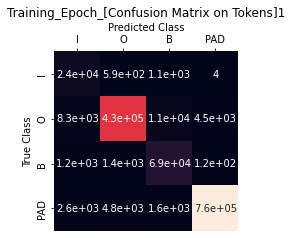

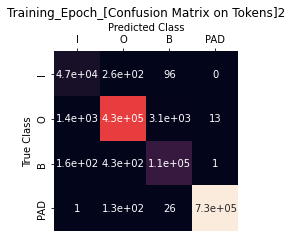

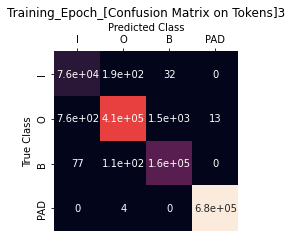

In [ ]:
history = finetune_procedure_bert_for_ner(model,epochs,train_dataloader,optimizer,criterion,scheduler,max_grad_norm,early_stopping = True,patience = 15,PATH = "BERT_BASE_CASED/state_dict")

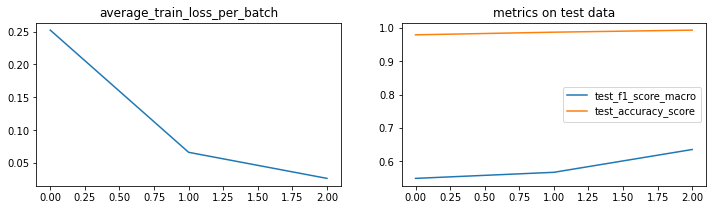

In [ ]:
print_training_results(history)

##### Bio-Clinical Bert

In [ ]:
class Token_Classifier_With_Pretrained_Bert_Base(torch.nn.Module):
  def __init__(self,base,classes = 4):
    super().__init__()
    self.n_classes = classes
    self.base = base
    self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
    self.classifier = torch.nn.Linear(in_features=768, out_features=classes, bias=True)
    self.criterion = torch.nn.CrossEntropyLoss()

  def forward(self,bert_input,attention_mask,token_type_ids = None,labels = None):
    out = self.base(bert_input,attention_mask = attention_mask,token_type_ids = None)[0]
    out = self.dropout(out)
    out = self.classifier(out)
    if labels is None:
      return out
    else:
      return (self.criterion(out.reshape(-1,4),labels.reshape(-1)),out)

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
base_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = Token_Classifier_With_Pretrained_Bert_Base(base_model,4)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
sentences = saved_sentences
labels = saved_labels

sentences,labels = get_tokenized_sentences_and_labels(sentences,labels,tokenizer)
normalize_longer_sequences()

for i,j in zip(sentences,labels):
  assert(len(i) == len(j))

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, tr_tags, tr_masks = input_ids, tags, attention_masks

tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
FULL_FINETUNING = True

###########################################

if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
epochs = 100
max_grad_norm = 1.0

#############################################

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
class_weight = [np.sum(np.array([np.sum(np.array(j) == tag2idx[w]) for j in tags])) for w in tag_values]
class_weight = 1 / np.array(class_weight,dtype = np.float32)
class_weight = np.array(class_weight) / np.array(class_weight).sum()

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weight).to("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
try :
    os.mkdir("BIO_CLINICAL_BERT")
except:
    pass

Epoch number 1:


100%|██████████| 543/543 [07:52<00:00,  1.15it/s]


Average_Train_Loss_per_Batch [On Tokens]: 0.21579097028816133


IndexError: ignored

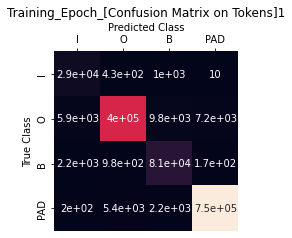

In [38]:
history = finetune_procedure_bert_for_ner(model,epochs,train_dataloader,optimizer,criterion,scheduler,max_grad_norm,early_stopping = True,patience = 15,PATH = "BIO_CLINICAL_BERT/state_dict")

In [ ]:
print_training_results(history)

##### BioELECTRA

In [ ]:
class Token_Classifier_From_BioElectra(torch.nn.Module):
  def __init__(self,base,classes = 4):
    super().__init__()
    self.n_classes = classes
    self.base = base.electra
    self.intermediate = base.discriminator_predictions.dense
    self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
    self.classifier = torch.nn.Linear(in_features=768, out_features=classes, bias=True)
    self.criterion = torch.nn.CrossEntropyLoss()

  def forward(self,bert_input,attention_mask,token_type_ids = None,labels = None):
    out = self.base(bert_input,attention_mask = attention_mask,token_type_ids = None).__getitem__(0)
    out = self.intermediate(out)
    out = self.dropout(out)
    out = self.classifier(out)
    if labels is None:
      return out
    else:
      return (self.criterion(out.reshape(-1,4),labels.reshape(-1)),out)

In [ ]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast

base_model = ElectraForPreTraining.from_pretrained("kamalkraj/bioelectra-base-discriminator-pubmed")
tokenizer = ElectraTokenizerFast.from_pretrained("kamalkraj/bioelectra-base-discriminator-pubmed")
model = Token_Classifier_From_BioElectra(base_model,4)

In [ ]:
sentences = saved_sentences
labels = saved_labels

sentences,labels = get_tokenized_sentences_and_labels(sentences,labels,tokenizer)
normalize_longer_sequences()

for i,j in zip(sentences,labels):
  assert(len(i) == len(j))

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, tr_tags, tr_masks = input_ids, tags, attention_masks

tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
FULL_FINETUNING = True

#######################################
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
epochs = 100
max_grad_norm = 1.0

#############################################

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
class_weight = [np.sum(np.array([np.sum(np.array(j) == tag2idx[w]) for j in tags])) for w in tag_values]
class_weight = 1 / np.array(class_weight,dtype = np.float32)
class_weight = np.array(class_weight) / np.array(class_weight).sum()

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weight).to("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
try :
    os.mkdir("BIO_ELECTRA")
except:
    pass

In [ ]:
history = finetune_procedure_bert_for_ner(model,epochs,train_dataloader,optimizer,criterion,scheduler,max_grad_norm,early_stopping = True,patience = 15,PATH = "BIO_ELECTRA/state_dict")

In [ ]:
print_training_results(history)

## Prediction

### Predictions

In [ ]:
%%time
PATH = "/content/drive/MyDrive/CMED/Data/trainingdata_v3/dev/100-01.txt"

sentences,labels,word_span_dataframe = get_ner_predictions(PATH,model,tokenizer,tag_values,True)